In [1]:
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import cm
from matplotlib import ticker

from matplotlib.colors import to_rgb
from tenpy.tools.misc import to_array
from tenpy.tools import hdf5_io
import h5py

def load_data_h5(fname):
    with h5py.File(fname, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        return data

cblue = '#0f3f67ff'
cred = '#d62d20'
cdarkred ='#a41212'
cgrey = '#c0c5ce'

In [2]:
def plot_ent_spect_color(ax, ent_spect, Ly, PRINT=False, permute=[], counting=[], Q=0):
    """
    Plot entanglement spectrum for a single charge sector Q as colored scatter points vs momentum.

    Parameters
    - ax : matplotlib.axes.Axes
        Axes object to draw the scatter plot on.
    - ent_spect : list
        List of tuples (q, s) returned by TenPy's entanglement_spectrum(by_charge=True).
        q is an array-like [charge, momentum], s is a 1D array of entanglement eigenvalues.
    - Ly : int
        Number of momentum sectors (used to set x-ticks and momentum grid).
    - PRINT : bool, optional
        If True, prints the eigenvalue arrays for the plotted sector(s).
    - permute : sequence of int, optional
        Permutation of momentum indices; length should be Ly. If length != Ly, defaults to np.arange(Ly).
    - counting : sequence of int, optional
        Per-momentum integer counts; the first `counting[k]` points at momentum k are drawn in a highlight color.
        If length != Ly, defaults to zeros.
    - Q : int, optional
        Charge sector to plot (only entries with q[0] == Q are drawn).

    Behavior / Notes
    - Uses global colormap cm.RdBu and the color constants defined in the notebook (e.g. cgrey).
    - Sets x-ticks to k = 0..Ly-1 scaled by 2*pi/Ly and labels them with `permute`.
    - Adds minor y-ticks and applies inwards tick styling.
    - Calls pl.show() at the end.
    - Returns None (draws on the provided Axes).
    """
    if len(permute) != Ly:
        permute = np.arange(Ly)
    
    if len(counting) != Ly:
        counting = np.zeros(Ly, dtype=int)
    for q,s in ent_spect:
        qo = np.array(q)
        q = [qo[0],qo[1]]
        # q[0] is charge, q[1] is momentum
        klist = np.arange(0, Ly) * 2 * np.pi / Ly
        if q[0] == Q:  # take selected charge excitations
            kVal = permute[q[1]]
            crls = [cgrey for nn in range(len(s))]
            for ii in range(counting[kVal]):
                crls[ii] = cm.RdBu(0.15)
            ax.scatter(np.zeros(s.shape) + klist[kVal], s, marker='o',
                       linewidths=0.3, edgecolors='black', c=crls)
            if PRINT:
                print(s)
        
    # Add minor ticks - Split major tick interval in two bins
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.tick_params(which='both', axis="both", direction='in')    

    ax.set_xticks(np.arange(Ly) * 2 * np.pi / Ly)
    labels = permute
    ax.set_xticklabels(labels)
    ax.set_xlabel(r"momentum $L_y \cdot k_y/2\pi$")
    ax.set_ylabel(r"eigenvalues $ \epsilon_\alpha $")

    pl.show()



def plot_ent_spect_allQ(ax, ent_spect, Ly, PRINT=False, permute=[], counting=[], legend=False):
    """
    Plot entanglement spectrum for multiple charge sectors on the same axes, color-coded by charge Q.

    Parameters
    - ax : matplotlib.axes.Axes
        Axes object to draw the scatter plots on.
    - ent_spect : list
        List of tuples (q, s) as from TenPy's entanglement_spectrum(by_charge=True).
    - Ly : int
        Number of momentum sectors (used to set x-ticks and momentum grid).
    - PRINT : bool, optional
        If True, prints the eigenvalue arrays as they are plotted.
    - permute : sequence of int, optional
        Permutation of momentum indices; length should be Ly. If length != Ly, defaults to np.arange(Ly).
    - counting : sequence of int, optional
        Per-momentum integer counts (currently unused for special styling in this routine).
    - legend : bool, optional
        If True, displays a legend mapping colors to charge Q.

    Behavior / Notes
    - Loops over Q in [-Qmax, ..., Qmax] (Qmax is hard-coded as 4 here) and plots points offset by 0.1*Q
      along x so different charges at the same momentum do not overlap exactly.
    - Uses cm.coolwarm for the Q color mapping.
    - Sets x-ticks to k = 0..Ly-1 scaled by 2*pi/Ly and labels them with `permute`.
    - Adds minor y-ticks and applies inwards tick styling.
    - Calls pl.show() at the end.
    - Returns None (draws on the provided Axes).

    Example
    - Call with the entanglement spectrum list produced by TenPy:
        plot_ent_spect_allQ(ax, ent_spect, Ly, legend=True)
    """
    if len(permute) != Ly:
        permute = np.arange(Ly)
    
    if len(counting) != Ly:
        counting = np.zeros(Ly, dtype=int)
    Qlist = []
    for q,s in ent_spect:
        qo = np.array(q)
        q = [qo[0],qo[1]]
        # q[0] is charge, q[1] is momentum
        klist = np.arange(0, Ly) * 2 * np.pi / Ly
        Qmax = 4
        crls_list = np.linspace(0, 1, 2*Qmax+1)
        for Q in range(-Qmax, Qmax+1):
            if q[0] == Q:
                kVal = permute[q[1]]
                if Q not in Qlist:
                    ax.scatter(np.zeros(s.shape) + klist[kVal] + 0.1*Q, s, marker='o',
                               linewidths=0.3, edgecolors='black',
                               color=cm.coolwarm(crls_list[Q+Qmax]), label=f'Q={Q:d}')
                else:
                    ax.scatter(np.zeros(s.shape) + klist[kVal] + 0.1*Q, s, marker='o',
                               linewidths=0.3, edgecolors='black',
                               color=cm.coolwarm(crls_list[Q+Qmax]))
                Qlist.append(Q)
                if PRINT:
                    print(s)
        
    # Add minor ticks - Split major tick interval in two bins
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.tick_params(which='both', axis="both", direction='in')    
    if legend:
        ax.legend(loc='best')

    ax.set_xticks(np.arange(Ly) * 2 * np.pi / Ly)
    labels = permute
    ax.set_xticklabels(labels)
    ax.set_xlabel(r"momentum $L_y \cdot k_y/2\pi$")
    ax.set_ylabel(r"eigenvalues $ \epsilon_\alpha $")

    pl.show()


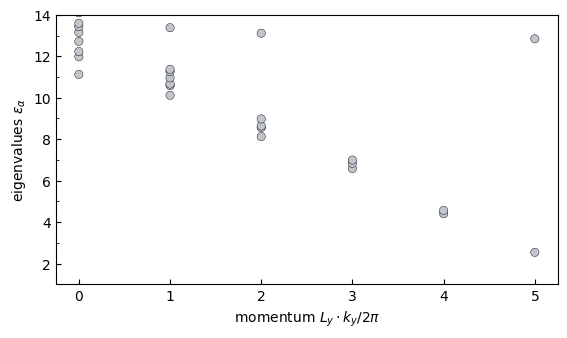

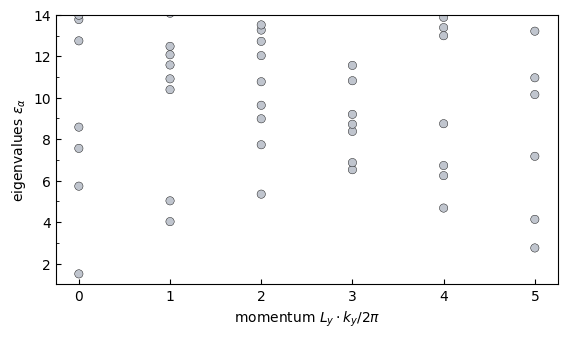

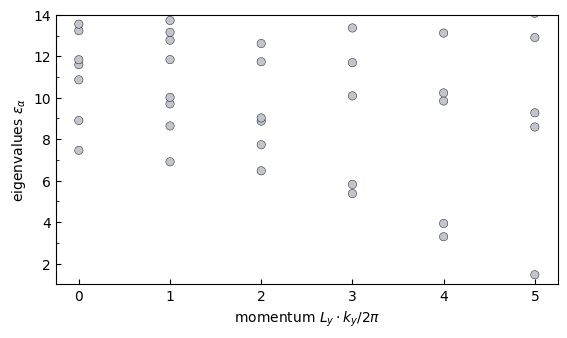

In [3]:
loc = '/home/t30/all/ge54yin/Documents/MasterThesisFQHinTMDs/MPS_stuff/MPScalculations/'
#modify as needed
V = 0.50
K = 1
Ly = 6
fname1 = f'extract_xk_Hofst_chi128_Lx2_Ly{Ly:d}_V{V:.2f}_t-1.00_D0.00_tp-0.25_N6_K3.h5'
fname2 = f'extract_xk_Hofst_chi128_Lx2_Ly{Ly:d}_V{V:.2f}_t-1.00_D0.00_tp-0.25_N4_K3.h5'
fname3 = f'extract_xk_Hofst_chi128_Lx2_Ly{Ly:d}_V{V:.2f}_t-1.00_D0.00_tp-0.25_N2_K3.h5'

data1 = load_data_h5(loc+fname1)
entspec1 = data1['ent_spect']
fig = pl.figure(figsize=(4*(1+np.sqrt(5))/2, 7/2))#,gridspec_kw={'height_ratios': [(1+np.sqrt(5))/2, 1]})
ax = pl.gca()
ax.set_ylim(1, 14)
#permute = [0, 5, 4, 3, 2, 1]
permute = np.arange(Ly)
plot_ent_spect_color(ax, entspec1, Ly, PRINT=False, permute=permute)

data2 = load_data_h5(loc+fname2)
entspec2 = data2['ent_spect']
fig = pl.figure(figsize=(4*(1+np.sqrt(5))/2, 7/2))#,gridspec_kw={'height_ratios': [(1+np.sqrt(5))/2, 1]})
ax = pl.gca()
ax.set_ylim(1, 14)
#permute = [0, 5, 4, 3, 2, 1]
permute = np.arange(Ly)
plot_ent_spect_color(ax, entspec2, Ly, PRINT=False, permute=permute)

data3 = load_data_h5(loc+fname3)
entspec3 = data3['ent_spect']
fig = pl.figure(figsize=(4*(1+np.sqrt(5))/2, 7/2))#,gridspec_kw={'height_ratios': [(1+np.sqrt(5))/2, 1]})
ax = pl.gca()
ax.set_ylim(1, 14)
#permute = [0, 5, 4, 3, 2, 1]
permute = np.arange(Ly)
plot_ent_spect_color(ax, entspec3, Ly, PRINT=False, permute=permute)